In [233]:
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro

# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y~X1+X2+...)
import statsmodels.formula.api as smf
# Scaling 클래스
from sklearn.preprocessing import scale, minmax_scale, robust_scale
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 선형회귀모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse
# Ridge, Lasso, ElasticNet 패키지 불러오기
from sklearn.linear_model import Ridge, Lasso, ElasticNet
# 데이터 분할: train, test
from sklearn.model_selection import train_test_split
# 예측/회귀 Decision Tress
from sklearn.tree import DecisionTreeRegressor
# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestRegressor
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# export_graphviz: 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화(.dot 확장자 파일 불러오기 등)
import graphviz
# MSE 계산
from sklearn.metrics import mean_squared_error
# MAE 계산
from sklearn.metrics import mean_absolute_error
# 예측/회귀 Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# Scale 변환: 평균, 표준편차 기준
from sklearn.preprocessing import StandardScaler

# 주성분 분석
from sklearn.decomposition import PCA
# 날짜 데이터 생성
from datetime import datetime
# 자기상관 함수, 부분 자기상관 함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ARIMA
from statsmodels.tsa.arima_model import ARIMA

# jupyter notebook 사용 시 그래프 자동 출력 옵션
# matplotlib 이용한 Background 그래프 실행 및 결과 확인
%matplotlib inline

# 음수 표시
plt.rc('axes', unicode_minus=False)
# 맑은 고딕 적용
plt.rc("font", family="Malgun Gothic")

# 랜덤 포레스트_실습

아래는 당뇨병 발병 원인과 관련되 데이터이다.   
당요병 발생을 예측하기 위해 랜던 포레스트 분석을 실시하고 결과를 해석하시오.  
- 데이터 : DIABETES.CSV(변수 : 11개, 자료 수 : 442개)

## 1. 데이터 구성하기

In [24]:
# 파일명, 변수, 값 등에 한글 포함시 engine="python" 지정
df_raw=pd.read_csv("../data/DIABETES.csv", engine="python")
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [25]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw["Y"]
df_raw_x=df_raw.drop("Y", axis=1, inplace=False)

In [26]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (309, 10)
train data Y size : (309,)
test data X size : (133, 10)
test data Y size : (133,)


In [27]:
rf_uncustomized=RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.919
Score on test set: 0.455


> 모델 설명력은 train 91.9% test 45.5%로 모델은 train 데이터에 과대적합

## 2. 모델 생성 및 Parameter 조정

- n_estimators: 트리 수 변경에 따른 모델 성능

In [28]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_tree: 잎사귀 최소 자료 수
para_n_tree=[n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(random_state=1234, n_estimators=v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_n=pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["TestScore"]=test_score

In [29]:
# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.892,0.393
1,20,0.908,0.404
2,30,0.908,0.432
3,40,0.911,0.442
4,50,0.914,0.458
5,60,0.915,0.454
6,70,0.915,0.451
7,80,0.917,0.451
8,90,0.919,0.450
9,100,0.919,0.455


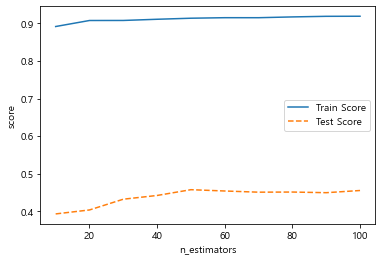

In [30]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

> 트리 수 증가에 따라 모델의 설명력은 지속적으로 향상되다가 50 이상 부터는 유지    
> Test 데이터의 성능 변화를 고려하여 50 선택

- min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [37]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestRegressor(random_state=1234, n_estimators=50, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

In [38]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.914,0.458
1,2,0.877,0.466
2,3,0.831,0.467
3,4,0.782,0.465
4,5,0.748,0.460
5,6,0.715,0.460
6,7,0.694,0.466
7,8,0.670,0.467
8,9,0.651,0.474
9,10,0.634,0.469


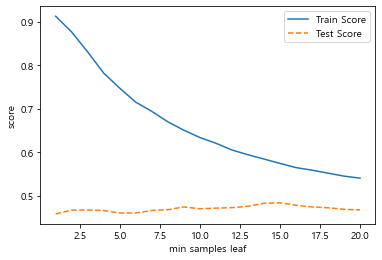

In [39]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

> 잎사귀 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소하며  
> 데이터의 성능 변화를 고려하여 15 선택

- min_sample_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [43]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_split: 잎사귀 최소 자료 수
para_split=[n_split*2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf=RandomForestRegressor(random_state=1234, n_estimators=50, min_samples_leaf=15,
                             min_samples_split=v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score

In [44]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.574,0.483
1,6,0.574,0.483
2,8,0.574,0.483
3,10,0.574,0.483
4,12,0.574,0.483
5,14,0.574,0.483
6,16,0.574,0.483
7,18,0.574,0.483
8,20,0.574,0.483
9,22,0.574,0.483


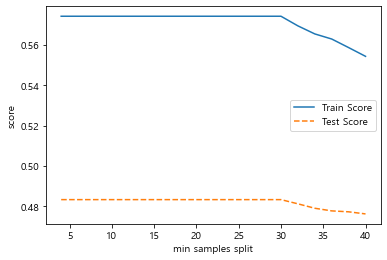

In [45]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

> 데이터의 성능 변화를 고려하여 30 선택

- max_depth: 최대 깊이 변경에 따른 모델 성능

In [46]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_depth: 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf=RandomForestRegressor(random_state=1234, n_estimators=50, min_samples_leaf=15,
                             min_samples_split=30, max_depth=v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth=pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score

In [47]:
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.386,0.399
1,2,0.488,0.469
2,3,0.546,0.489
3,4,0.567,0.485
4,5,0.574,0.484
5,6,0.574,0.483
6,7,0.574,0.483
7,8,0.574,0.483
8,9,0.574,0.483
9,10,0.574,0.483


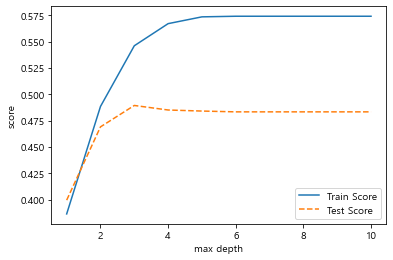

In [48]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

> 데이터의 성능 변화를 고려하여 3 선택

> 직접 모델 parameter를 조정해가면서 얻은 값 :  
> n_estimators=50, min_samples_leaf=15, min_samples_split=30, max_depth=3

- GridSearchCV를 이용한 최적 parameter 찾기

In [49]:
estimator=RandomForestRegressor()
# 구하고자 하는 parameter와 범위
param_grid={"max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
RandomForestRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=14)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 14}

best score: 
0.425


### 3. 최종 모델 선정

- 예측값을 구하고 MSE / MAE 비교

In [50]:
# 직접 모델 parameter를 조정해가면서 얻은 값
reg = RandomForestRegressor(random_state=1234, min_samples_leaf=3, min_samples_split=7, max_depth=6)
reg.fit(df_train_x, df_train_y)
y_pred1 = reg.predict(df_test_x)

In [51]:
# MSE / MAE
print("MSE :", mean_squared_error(df_test_y, y_pred1))
print("MAE :", mean_absolute_error(df_test_y, y_pred1))

MSE : 2951.924216007468
MAE : 44.5333742103775


In [52]:
# GridSearchCV를 통해 얻은 값
reg = RandomForestRegressor(random_state=1234, min_samples_leaf=10, min_samples_split=14, max_depth=9)
reg.fit(df_train_x, df_train_y)
y_pred2 = reg.predict(df_test_x)

In [53]:
# MSE / MAE
print("MSE :", mean_squared_error(df_test_y, y_pred2))
print("MAE :", mean_absolute_error(df_test_y, y_pred2))

MSE : 2923.996061240053
MAE : 44.845088752994165


 **[결론]**  
GridSearchCV를 통해 얻은   
parameter 값(min_samples_leaf=10, min_samples_split=14, max_depth=9)을 사용할 때,  
MSE와 더 작기 때문에 더 좋은 모델이라고 할 수 있다.

In [54]:
# 최종 모델
rf_final=RandomForestRegressor(random_state=1234, n_estimators=50, min_samples_leaf=10,
                             min_samples_split=14, max_depth=9)
rf_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))
rf_final

Score on training set: 0.634
Score on test set: 0.469


RandomForestRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=14,
                      n_estimators=50, random_state=1234)

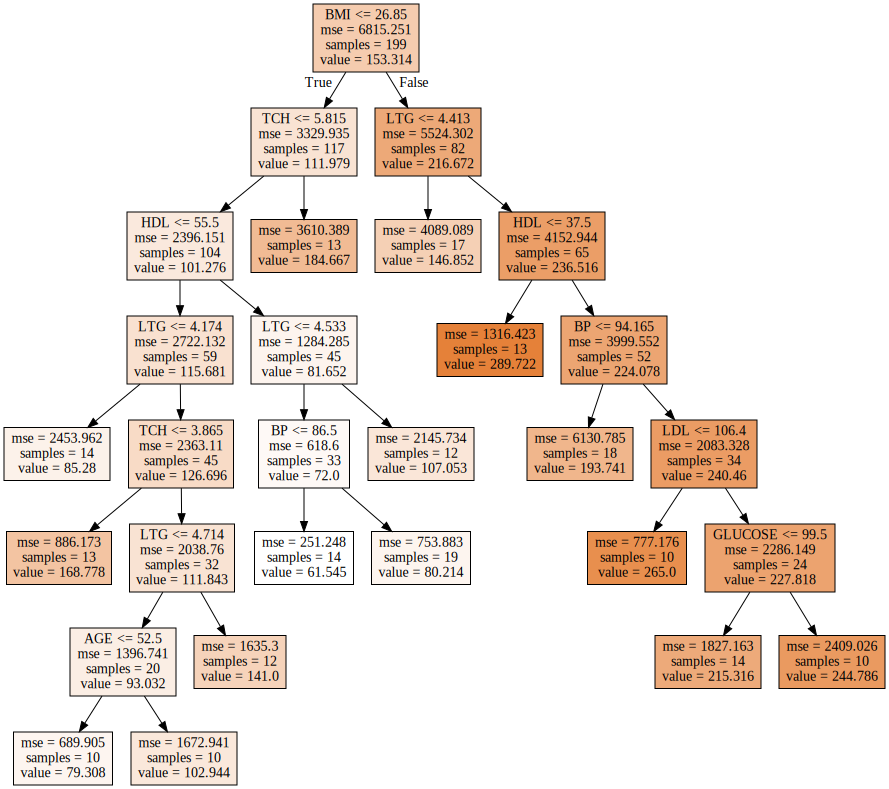

In [55]:
# 변수명 저장
v_feature_name=df_train_x.columns
# 0번 트리
export_graphviz(rf_final.estimators_[0], out_file="rfr_final_0.dot", feature_names=v_feature_name, impurity=True, filled=True)
# tree_final_0.dot 그리기
with open("rfr_final_0.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

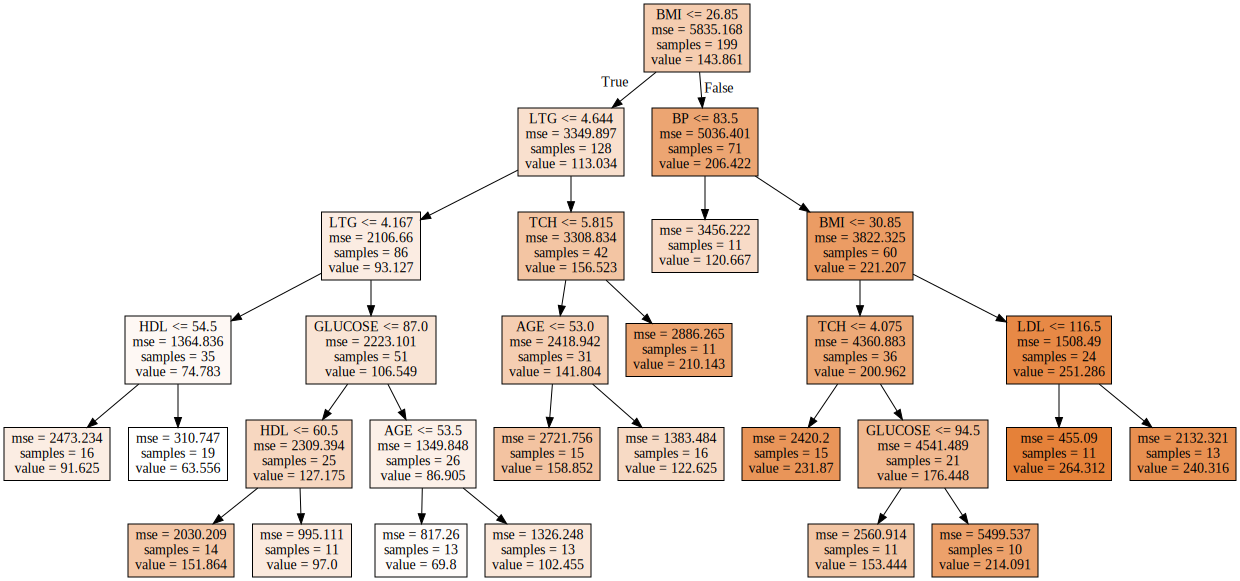

In [56]:
# 1번 트리
export_graphviz(rf_final.estimators_[1], out_file="rfr_final_1.dot", feature_names=v_feature_name, impurity=True, filled=True)
# tree_final_1.dot 그리기
with open("rfr_final_1.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

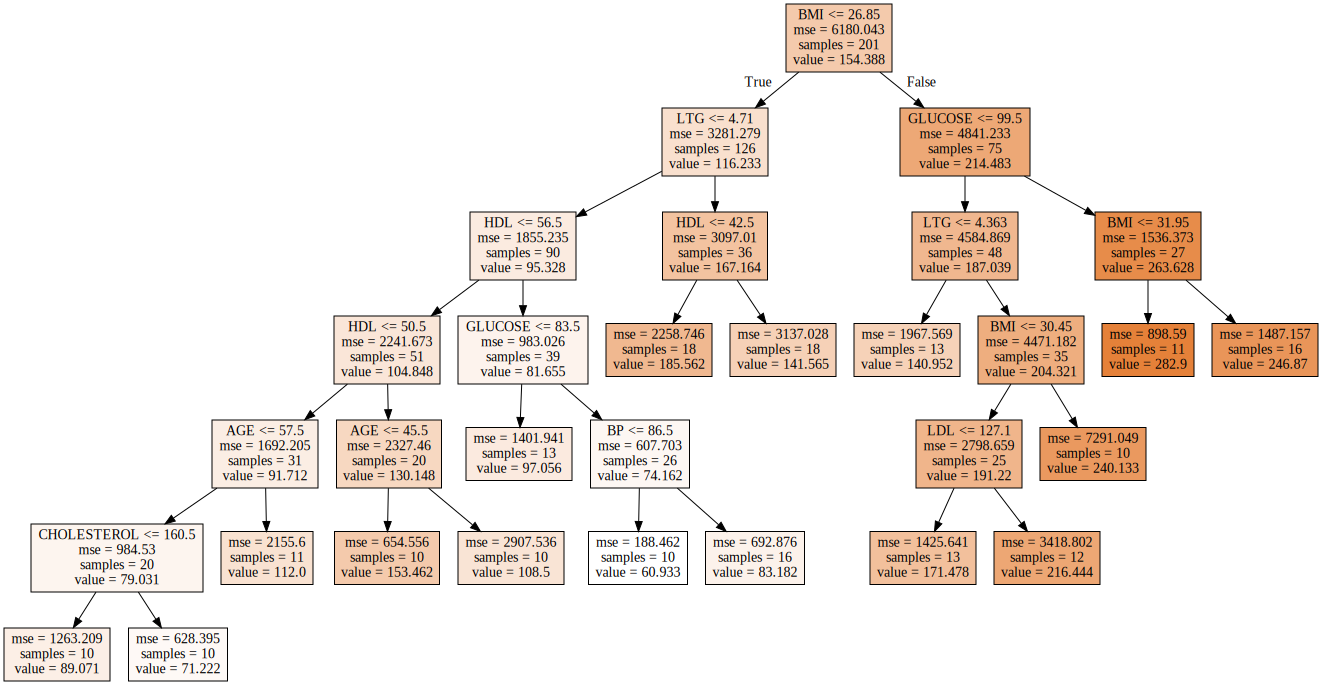

In [57]:
# 10번 트리
export_graphviz(rf_final.estimators_[10], out_file="rfr_final_10.dot", feature_names=v_feature_name, impurity=True, filled=True)
# tree_final_10.dot 그리기
with open("rfr_final_10.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [58]:
# 결론 도출
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.401
8,LTG,0.328
9,GLUCOSE,0.068
3,BP,0.060
6,HDL,0.045
5,LDL,0.027
7,TCH,0.023
0,AGE,0.020
4,CHOLESTEROL,0.018
1,GENDER,0.009


Text(0, 0.5, '변수')

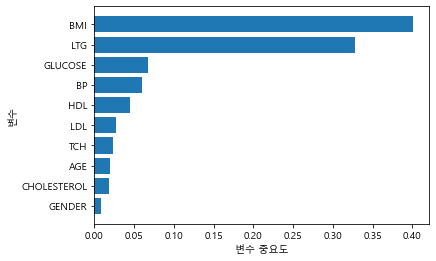

In [59]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## **[결론]**  
중요 설명변수 : BMI, LTG 순으로 영향이 크다고 해석할 수 있음 

# 그래디언트 부스팅

아래는 감독자의 체질검사 데이터이다.  
체질 비만도를 예측하기 위한 그래디언트 부스팅 분석을 실시하고 결과를 해석하시오.  
- 데이터: 체질검사.CSV(변수: 14, 자료 수: 252개)

## 1. 데이터 구성하기

In [60]:
# 파일명, 변수, 값 등에 한글 포함시 engine="python" 지정
df_raw=pd.read_csv("../data/체질검사.csv", engine="python")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [61]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw["FAT"]
df_raw_x=df_raw.drop("FAT", axis=1, inplace = False)

In [62]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (176, 13)
train data Y size : (176,)
test data X size : (76, 13)
test data Y size : (76,)


## 2. 모델 생성 및 Parameter 조정

In [63]:
# 모델 생성 : GradientBoostingRegressor
gb_uncustomized=GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.981
Score on test set: 0.581


> 모델 설명력은 train 98.1% test 58.1%로 모델은 train 데이터에 과대적합

- n_estimators: 트리 수 변경에 따른 모델 성능

In [64]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_tree: 잎사귀 최소 자료 수
para_n_tree=[n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_n=pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["TestScore"]=test_score

In [65]:
# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.712,0.512
1,20,0.850,0.589
2,30,0.897,0.600
3,40,0.921,0.599
4,50,0.942,0.587
5,60,0.954,0.586
6,70,0.963,0.587
7,80,0.970,0.581
8,90,0.976,0.582
9,100,0.981,0.581


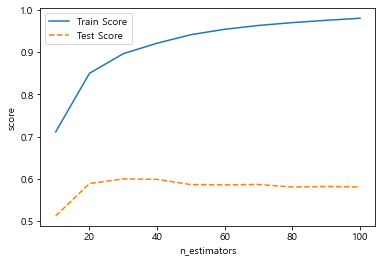

In [66]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

> 트리 수 증가에 따라 모델의 설명력은 지속적으로 향상되고 있으나  
> Test 데이터의 성능 변화를 고려하여 30 선택

- min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [67]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

In [68]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.897,0.600
1,2,0.899,0.599
2,3,0.896,0.594
3,4,0.893,0.586
4,5,0.890,0.604
5,6,0.888,0.596
6,7,0.884,0.590
7,8,0.874,0.610
8,9,0.879,0.598
9,10,0.873,0.587


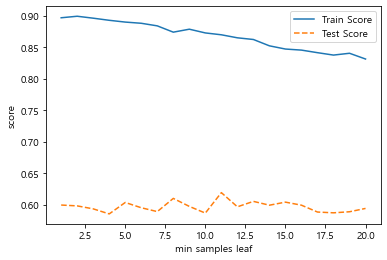

In [69]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

> 잎사귀 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소하며  
> test 데이터의 성능 변화를 고려하여 11 선택

- min_sample_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [70]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_split: 잎사귀 최소 자료 수
para_split=[n_split*2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=11,
                             min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score

In [71]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.870,0.620
1,6,0.870,0.620
2,8,0.870,0.620
3,10,0.870,0.620
4,12,0.870,0.620
5,14,0.870,0.620
6,16,0.870,0.620
7,18,0.870,0.620
8,20,0.870,0.620
9,22,0.870,0.620


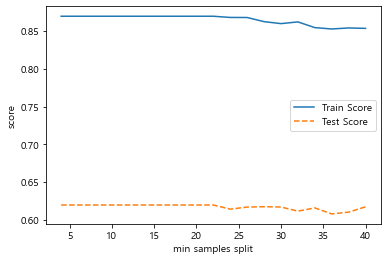

In [72]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

> 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소하며  
> Train/test 데이터의 성능 변화를 고려하여 22 선택  
> 22보다 적은 영역에서는 변화가 없음

- max_depth: 최대 깊이 변경에 따른 모델 성능

In [73]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_depth: 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=11,
                             min_samples_split=22, max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth=pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score

In [74]:
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.703,0.592
1,2,0.800,0.600
2,3,0.870,0.620
3,4,0.900,0.629
4,5,0.913,0.613
5,6,0.917,0.614
6,7,0.920,0.613
7,8,0.920,0.615
8,9,0.921,0.609
9,10,0.922,0.616


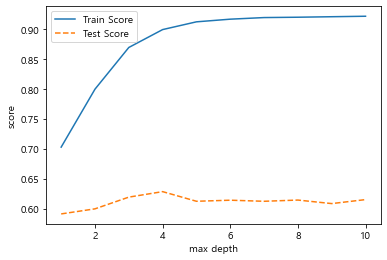

In [75]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

> 최대 깊이 증가에 따라 모델의 설명력은 증가하며  
> test 데이터의 성능 변화를 고려하여 4 선택

- learning_rate: 학습률 변경에 따른 모델 성능

In [78]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_lr: 잎사귀 최소 자료 수
para_lr=[lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=11,
                             min_samples_split=22, max_depth=4, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_lr=pd.DataFrame()
df_score_lr["LearningRate"]=para_lr
df_score_lr["TrainScore"]=train_score
df_score_lr["TestScore"]=test_score

In [79]:
# 모델 설명력 확인
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.900,0.629
1,0.2,0.940,0.588
2,0.3,0.966,0.566
3,0.4,0.981,0.539
4,0.5,0.984,0.533
5,0.6,0.990,0.527
6,0.7,0.993,0.478
7,0.8,0.994,0.437
8,0.9,0.997,0.464


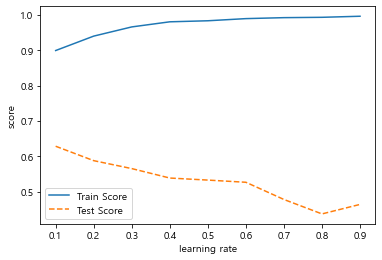

In [80]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle="-", label="Train Score")
plt.plot(para_lr, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()

> 학습률 증가에 따라 모델의 설명력은 증가하는데  
> 반면 test 데이터의 성능은 급격하게 저하되어 0.1 선택  
> 0.1~0.2 사이의 세밀한 변화에 따른 성능 확인 필요

## 3. 결론 도출

In [82]:
# 최종 모델
gb_final=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=11,
                             min_samples_split=22, max_depth=4, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.900
Score on test set: 0.629


In [84]:
# 변수명 저장
v_feature_name=df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.775
2,HEIGHT,0.038
12,WRIST,0.025
3,NECK,0.023
6,HIP,0.021
4,CHEST,0.021
0,AGE,0.021
7,THIGH,0.020
8,KNEE,0.017
10,BICEPS,0.014


Text(0, 0.5, '변수')

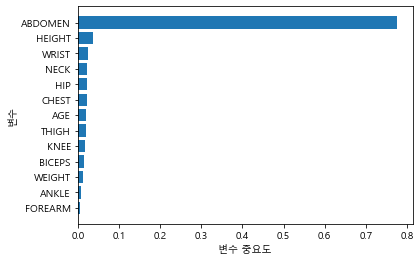

In [85]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

> 중요 설명변수:복부 둘레(ABDOMEN), 키(HEIGHT), 손목 둘레(WRIST) 순으로 영향이 크다고 해석할 수 있음  
> 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

In [88]:
# estimator=GradientBoostingRegressor(random_state=1234)
# # 구하고자 하는 parameter와 범위
# param_grid={"criterion":["mse", "friedman_mse", "mae"], "max_features" : ["auto", "sqrt", "log2"], 
#             "learning_rate":para_lr, "max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}
# # 설명력이 높은 최적 parameter 찾기
# grid_gb = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
# grid_gb.fit(df_train_x, df_train_y)

# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_gb.best_params_))
# print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

# 그래디언트 부스팅 실습

아래는 당뇨병 발병 원인과 관련된 데이터이다.  
당뇨병 발생을 예측하기 위해 그레디언트 부스팅 분석을 실시하고 결과를 해석하시오.  
- 데이터: DIABETES.CSV(변수:11개, 자료 수: 442개)

## 1. 데이터 구성하기

In [89]:
# 파일명, 변수, 값 등에 한글 포함시 engine="python" 지정
df_raw=pd.read_csv("../data/DIABETES.csv", engine="python")
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [92]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw["Y"]
df_raw_x=df_raw.drop("Y", axis=1, inplace = False)

In [93]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (309, 10)
train data Y size : (309,)
test data X size : (133, 10)
test data Y size : (133,)


## 2. 모델 생성 및 Parameter 조정

In [94]:
# 모델 생성 : GradientBoostingRegressor
gb_uncustomized=GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.865
Score on test set: 0.451


> 모델 설명력은 train 86.5% test 45.1%로 모델은 train 데이터에 과대적합

- n_estimators: 트리 수 변경에 따른 모델 성능

In [95]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_tree: 잎사귀 최소 자료 수
para_n_tree=[n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_n=pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["TestScore"]=test_score

In [96]:
# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.504,0.430
1,20,0.639,0.494
2,30,0.707,0.500
3,40,0.751,0.486
4,50,0.778,0.480
5,60,0.802,0.471
6,70,0.825,0.465
7,80,0.841,0.462
8,90,0.852,0.458
9,100,0.865,0.451


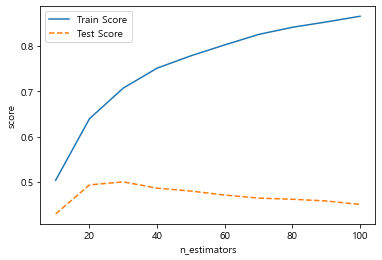

In [97]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

> 트리 수 증가에 따라 모델의 설명력은 지속적으로 향상되고 있으나  
> Test 데이터의 성능 변화를 고려하여 30 선택

- min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [119]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

In [120]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.707,0.500
1,2,0.708,0.505
2,3,0.701,0.505
3,4,0.700,0.492
4,5,0.691,0.468
5,6,0.683,0.492
6,7,0.682,0.496
7,8,0.675,0.490
8,9,0.679,0.498
9,10,0.684,0.502


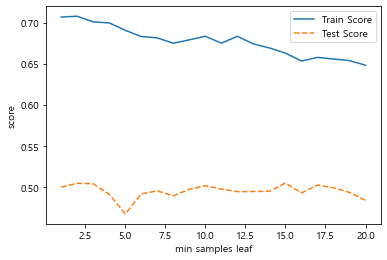

In [121]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

> 잎사귀 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소하며  
> test 데이터의 성능 변화를 고려하여 15 선택

- min_sample_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [122]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_split: 잎사귀 최소 자료 수
para_split=[n_split*2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=15,
                             min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score

In [123]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.663,0.505
1,6,0.663,0.505
2,8,0.663,0.505
3,10,0.663,0.505
4,12,0.663,0.505
5,14,0.663,0.505
6,16,0.663,0.505
7,18,0.663,0.505
8,20,0.663,0.505
9,22,0.663,0.505


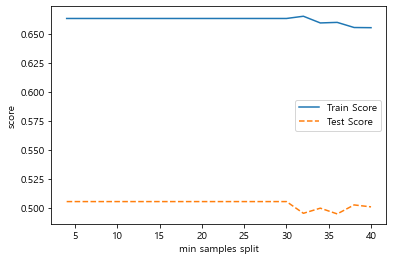

In [124]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

> Train/test 데이터의 성능 변화를 고려하여 30 선택  

- max_depth: 최대 깊이 변경에 따른 모델 성능

In [125]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_depth: 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=15,
                             min_samples_split=30, max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth=pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score

In [126]:
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.486,0.495
1,2,0.579,0.512
2,3,0.663,0.505
3,4,0.729,0.478
4,5,0.770,0.468
5,6,0.790,0.454
6,7,0.803,0.461
7,8,0.806,0.476
8,9,0.809,0.472
9,10,0.811,0.475


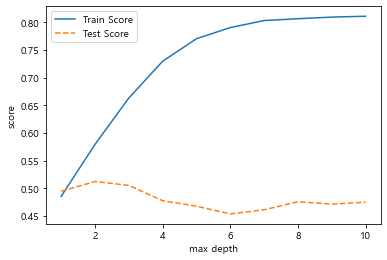

In [127]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

> 최대 깊이 증가에 따라 모델의 설명력은 증가하며  
> test 데이터의 성능 변화를 고려하여 2 선택

- learning_rate: 학습률 변경에 따른 모델 성능

In [128]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_lr: 잎사귀 최소 자료 수
para_lr=[lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=15,
                             min_samples_split=30, max_depth=2, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_lr=pd.DataFrame()
df_score_lr["LearningRate"]=para_lr
df_score_lr["TrainScore"]=train_score
df_score_lr["TestScore"]=test_score

In [129]:
# 모델 설명력 확인
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.579,0.512
1,0.2,0.652,0.511
2,0.3,0.694,0.493
3,0.4,0.726,0.458
4,0.5,0.744,0.435
5,0.6,0.759,0.390
6,0.7,0.796,0.315
7,0.8,0.781,0.344
8,0.9,0.804,0.233


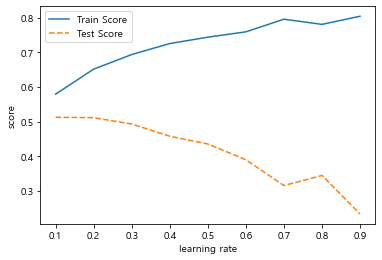

In [130]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle="-", label="Train Score")
plt.plot(para_lr, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()

> 학습률 증가에 따라 모델의 설명력은 증가하는데  
> 반면 test 데이터의 성능은 급격하게 저하되어 0.1 선택  
> 0.1~0.2 사이의 세밀한 변화에 따른 성능 확인 필요

## 3. 결론 도출

In [131]:
# 최종 모델
gb_final=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=15,
                             min_samples_split=30, max_depth=2, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.579
Score on test set: 0.512


In [132]:
# 변수명 저장
v_feature_name=df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.424
8,LTG,0.366
9,GLUCOSE,0.065
3,BP,0.062
6,HDL,0.039
7,TCH,0.016
1,GENDER,0.011
5,LDL,0.009
0,AGE,0.007
4,CHOLESTEROL,0.000


Text(0, 0.5, '변수')

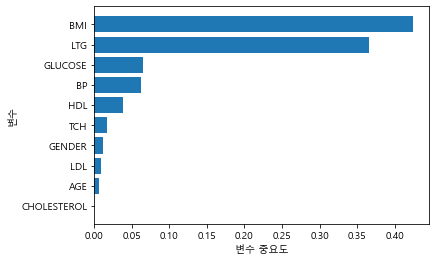

In [133]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

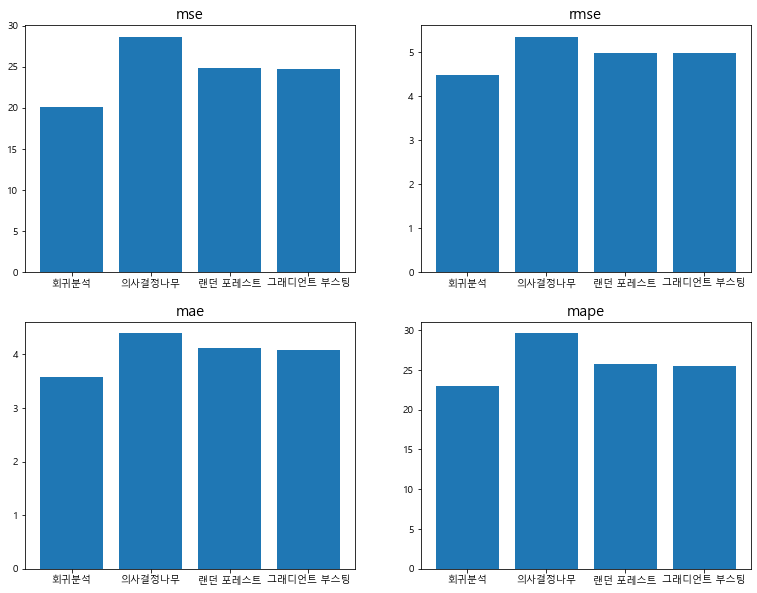

In [148]:
fig, ax=plt.subplots(2, 2, figsize=(13, 10))
ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)

> 후진제거로 선택된 설명변수를 이용한 선형회귀모델의 정확도가 가장 높고,  
> 반면에 의사결정나무 모델의 성능이 가장 미흡하며   
> 평가 지표별 모델의 정확도 추세는 유사하게 나타남

# 모델 평가_실습

아래는 당뇨병 발병 원인과 관련된 데이터이다.  
예측 모델을 이용하여 얻은 예측값으로 MSE, RMSE, MAE 그리고 MAPE를 계산하시오.  
- 데이터: DIABETES.CSV(변수:11개, 자료 수: 442개)

## 1. 데이터 구성하기

In [150]:
# 파일명, 변수, 값 등에 한글 포함시 engine="python" 지정
df_raw=pd.read_csv("../data/DIABETES.csv", engine="python")
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [152]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw["Y"]
df_raw_x=df_raw.drop("Y", axis=1, inplace = False)

In [153]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (309, 10)
train data Y size : (309,)
test data X size : (133, 10)
test data Y size : (133,)


## 2. 예측 모델 생성

In [155]:
para_leaf=[n_leaf*1 for n_leaf in range(1, 20)]
para_split=[n_split*2 for n_split in range(2, 20)]
para_depth=[depth for depth in range(1, 11)]

In [156]:
estimator=DecisionTreeRegressor()
# 구하고자 하는 parameter와 범위
param_grid={"criterion":["mse", "friedman_mse", "mae"], "max_features":["auto", "sqrt", "log2"],
           "max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      max_features='log2', min_samples_leaf=15,
                      min_samples_split=36)

best parameter: 
{'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 15, 'min_samples_split': 36}

best score: 
0.42


In [157]:
# 회귀 모델
lr_model=smf.ols(formula="Y~GENDER+BMI+HDL+TCH+LTG", data=df_raw)
lr_result=lr_model.fit()
print(lr_result.summary())

# Decision Tree
dt_model=DecisionTreeRegressor(random_state=1234, min_samples_leaf=15, min_samples_split=36, max_depth=3)
dt_model.fit(df_train_x, df_train_y)

# Random Forest
rf_model=RandomForestRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=14,
                      n_estimators=50, random_state=1234)
rf_model.fit(df_train_x, df_train_y)

# Gradient Boosting
gb_model=GradientBoostingRegressor(random_state=1234, n_estimators=30, min_samples_leaf=15,
                             min_samples_split=30, max_depth=2, learning_rate=0.1)
gb_model.fit(df_train_x, df_train_y)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     80.55
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           9.30e-60
Time:                        13:15:40   Log-Likelihood:                -2402.6
No. Observations:                 442   AIC:                             4817.
Df Residuals:                     436   BIC:                             4842.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -186.1265     37.219     -5.001      0.0

GradientBoostingRegressor(max_depth=2, min_samples_leaf=15,
                          min_samples_split=30, n_estimators=30,
                          random_state=1234)

## 3. 예측 및 평가

In [158]:
# 모델 리스트, 그래프를 그리기 생성 목적
models=["회귀분석", "의사결정나무", "랜던 포레스트", "그래디언트 부스팅"]
# 평가 리스트 초기화
mse, rmse, mae, mape=[],[],[],[]

- 회귀분석

In [159]:
# 예측
lr_y_pred=lr_result.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, lr_y_pred))
rmse.append(root_mean_squared_error(df_test_y, lr_y_pred))
mae.append(mean_absolute_error(df_test_y, lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, lr_y_pred))

- 의사결정나무

In [160]:
# 예측
dt_y_pred=dt_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

- 랜덤 포레스트

In [161]:
# 예측
rf_y_pred=rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

- 그래디언트 부스팅

In [162]:
# 예측
gb_y_pred=gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

## 4. 시각화

- 평가

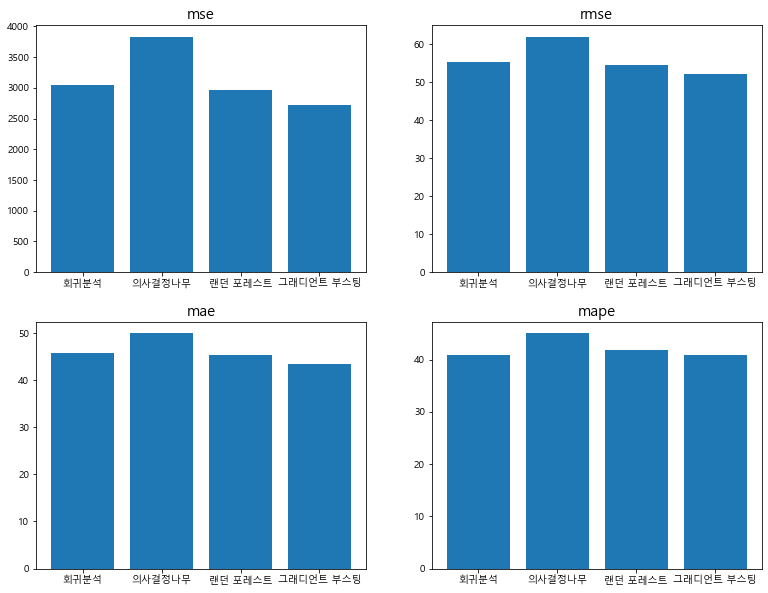

In [163]:
fig, ax=plt.subplots(2, 2, figsize=(13, 10))
ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)

> 후진제거로 선택된 설명변수를 이용한 선형회귀모델의 정확도가 가장 높고,  
> 반면에 의사결정나무 모델의 성능이 가장 미흡하며   
> 평가 지표별 모델의 정확도 추세는 유사하게 나타남

In [164]:
gb_y_pred = gb_model.predict(df_test_x)
models.append("그래디언트부스팅")
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

model_eval = pd.DataFrame()
model_eval["Model"] = models
model_eval["MSE"] = mse
model_eval["RMSE"] = rmse
model_eval["MAE"] = mae
model_eval["MAPE"] = mape
model_eval

,Model,MSE,RMSE,MAE,MAPE
0,회귀분석,3052.989114,55.253861,45.731955,40.790632
1,의사결정나무,3830.364600,61.889939,49.906617,45.017316
2,랜던 포레스트,2957.928718,54.386843,45.410365,41.849816
3,그래디언트 부스팅,2718.438994,52.138652,43.366749,40.849904
4,그래디언트부스팅,2718.438994,52.138652,43.366749,40.849904


# 주성분 분석(PCA)

아래는 감독자의 직무능력평가 데이터이다.  
차원 축소 및 주성분 탐색을 위해 주성분 분석을 실시하고 결과를 해석하시오.  
- 데이터: 직무능력평가.CSV(변수: 7개, 자료 수 : 30개)

## 1. 데이터 구성하기

In [167]:
df_raw=pd.read_csv("../data/직무능력평가.csv", engine="python")
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


In [169]:
# 데이터 분리(Y, Xs) -> 설명변수를 이용한 주성분 분석
df_raw_x=df_raw.drop("EVAL", axis=1)
df_raw_y=df_raw["EVAL"]
display(df_raw_y.head())
display(df_raw_x.head())

0    43
1    63
2    71
3    61
4    81
Name: EVAL, dtype: int64

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,51,30,39,61,92,45
1,64,51,54,63,73,47
2,70,68,69,76,86,48
3,63,45,47,54,84,35
4,78,56,66,71,83,47


## 2. 선형관계 확인

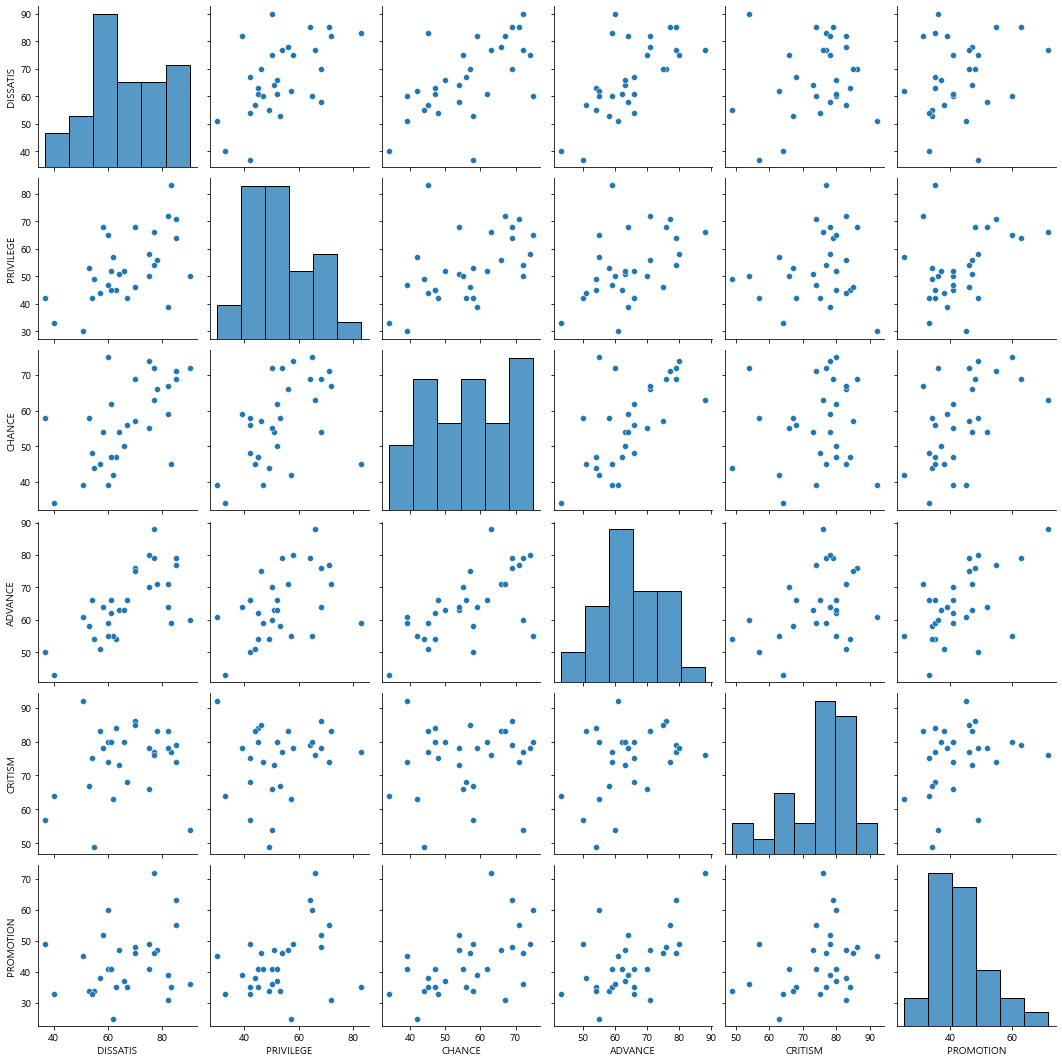

In [170]:
# 산점도 행렬
sns.pairplot(df_raw_x)

In [171]:
# Pearson 상관계수: pearson, kendall, spearman
df_raw_x.corr().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
DISSATIS,1.000,0.558,0.597,0.669,0.188,0.225
PRIVILEGE,0.558,1.000,0.493,0.445,0.147,0.343
CHANCE,0.597,0.493,1.000,0.640,0.116,0.532
ADVANCE,0.669,0.445,0.640,1.000,0.377,0.574
CRITISM,0.188,0.147,0.116,0.377,1.000,0.283
PROMOTION,0.225,0.343,0.532,0.574,0.283,1.000


> DISSATIS는 CHANCE(0.597), ADVANCE(0.669)와 상관관계가 높음  
> CHANCE는 ADVANCE(0.640)와 상관관계가 높음  

## 3. 데이터 확인 및 Scaling

In [172]:
# 요약 통계량 -> Scale 변환 필요 확인
df_raw_x.describe().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
count,30.000,30.000,30.000,30.000,30.000,30.000
mean,66.600,53.133,56.367,64.633,74.767,42.933
std,13.315,12.235,11.737,10.397,9.895,10.289
min,37.000,30.000,34.000,43.000,49.000,25.000
25%,58.500,45.000,47.000,58.250,69.250,35.000
50%,65.000,51.500,56.500,63.500,77.500,41.000
75%,77.000,62.500,66.750,71.000,80.000,47.750
max,90.000,83.000,75.000,88.000,92.000,72.000


In [173]:
# 변수 이름 저장
x_cols=df_raw_x.columns
# Scale 변환: ndarray 형식
scaler=StandardScaler()
nd_scaled=scaler.fit_transform(df_raw_x)
# 변환된 데이터 및 형태 확인
print("Scaled Data: \n {}".format(nd_scaled[:5].round(3)))
print("Shape:\n{}".format(nd_scaled.shape))

Scaled Data: 
 [[-1.192 -1.923 -1.505 -0.355  1.771  0.204]
 [-0.199 -0.177 -0.205 -0.16  -0.182  0.402]
 [ 0.26   1.236  1.095  1.112  1.155  0.501]
 [-0.275 -0.676 -0.812 -1.04   0.949 -0.784]
 [ 0.871  0.238  0.835  0.623  0.846  0.402]]
Shape:
(30, 6)


In [174]:
# DataFrame으로 저장
df_scaled=pd.DataFrame(nd_scaled, columns=x_cols)
df_scaled.head().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,-1.192,-1.923,-1.505,-0.355,1.771,0.204
1,-0.199,-0.177,-0.205,-0.160,-0.182,0.402
2,0.260,1.236,1.095,1.112,1.155,0.501
3,-0.275,-0.676,-0.812,-1.040,0.949,-0.784
4,0.871,0.238,0.835,0.623,0.846,0.402


In [175]:
# Scale 변환 데이터 요약 통계량
df_scaled.describe().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
count,30.000,30.000,30.000,30.000,30.000,30.000
mean,0.000,-0.000,-0.000,-0.000,0.000,0.000
std,1.017,1.017,1.017,1.017,1.017,1.017
min,-2.261,-1.923,-1.938,-2.116,-2.649,-1.773
25%,-0.619,-0.676,-0.812,-0.624,-0.567,-0.784
50%,-0.122,-0.136,0.012,-0.111,0.281,-0.191
75%,0.794,0.779,0.900,0.623,0.538,0.476
max,1.787,2.483,1.615,2.286,1.771,2.873


## 4. 주성분 분석

In [176]:
# 주성분 분석: 주성분1(Prin1)~주성분6(Prin6) 생성 및 저장
pca=PCA(n_components=6)
nd_pca=pca.fit_transform(df_scaled)
# 생성된 주성분 점수 확인
print("PCA Data :\n{}".format(nd_pca[:5]))
# 생성된 주성분 점수 Row, Column 개수 확인
print("Shape: \n {}".format(nd_pca.shape))

PCA Data :
[[ 1.67606983 -2.73856419 -0.12843595 -0.50321261  0.24330658  0.22576117]
 [ 0.21834397 -0.12615302  0.43115839  0.08726221  0.19566103  0.1941439 ]
 [-2.10515127 -0.51500683 -0.27683087  0.49131136 -0.44691698 -0.63174369]
 [ 1.35994032 -0.86064574 -0.91799066  0.03173793 -0.40137177  0.44095403]
 [-1.5120347  -0.35277019 -0.32684445 -0.32877858 -0.32709718  0.21246099]]
Shape: 
 (30, 6)


In [177]:
# 주성분 점수 저장(Prin1~Prin6, DataFrame형식) 및 확인
df_pca=pd.DataFrame(nd_pca, columns=["Prin1", "Prin2", "Prin3", "Prin4", "Prin5", "Prin6"])
# 주성분 분석용 데이터와 주성분 점수 결합
df_scaled_pca = df_scaled.join(df_pca)
df_scaled_pca.head()

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6
0,-1.191662,-1.923006,-1.504945,-0.355426,1.771410,0.204301,1.676070,-2.738564,-0.128436,-0.503213,0.243307,0.225761
1,-0.198610,-0.177338,-0.205088,-0.159779,-0.181595,0.402012,0.218344,-0.126153,0.431158,0.087262,0.195661,0.194144
2,0.259721,1.235822,1.094768,1.111930,1.154672,0.500868,-2.105151,-0.515007,-0.276831,0.491311,-0.446917,-0.631744
3,-0.274999,-0.676100,-0.811688,-1.040192,0.949092,-0.784254,1.359940,-0.860646,-0.917991,0.031738,-0.401372,0.440954
4,0.870830,0.238298,0.834797,0.622811,0.846302,0.402012,-1.512035,-0.352770,-0.326844,-0.328779,-0.327097,0.212461


In [184]:
# 주성분 분석 통계량 저장:주성분 번호, Eigenvalue, Eigenvalue ratio
df_pca_stat=pd.DataFrame()
df_pca_stat["PrinNo"]=[l for l in range(1, 7)]
df_pca_stat["EigenValues"]=pca.explained_variance_
df_pca_stat["EigenValueRatio"]=pca.explained_variance_ratio_
df_pca_stat["CumEigenValueRatio"]=np.cumsum(pca.explained_variance_ratio_)
df_pca_stat.round(3)

,PrinNo,EigenValues,EigenValueRatio,CumEigenValueRatio
0,1,3.279,0.528,0.528
1,2,1.041,0.168,0.696
2,3,0.789,0.127,0.823
3,4,0.572,0.092,0.915
4,5,0.328,0.053,0.968
5,6,0.198,0.032,1.000


> 적정 주성분 선택  
> : 상관계수 기준(고유값>1) 2개  
> : 공분산 기준(고유값 누적비율>0.8) 3개  

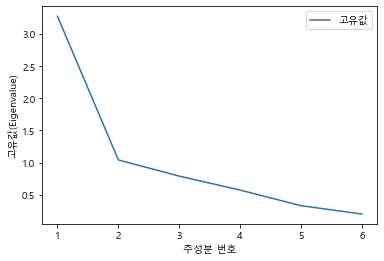

In [185]:
# Scree Plot
plt.plot(df_pca_stat["PrinNo"], df_pca_stat["EigenValues"], label="고유값")
# 그래프 label, legend 설정
plt.ylabel("고유값(Eigenvalue)")
plt.xlabel("주성분 번호")
plt.legend(loc="best")

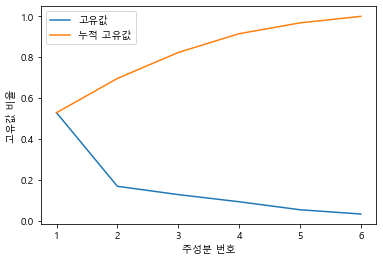

In [186]:
# 고유값 비율 그래프 생성
plt.plot(df_pca_stat["PrinNo"], df_pca_stat["EigenValueRatio"], label="고유값")
# 누적된 고유값 비율 그래프 생성
plt.plot(df_pca_stat["PrinNo"], df_pca_stat["CumEigenValueRatio"], label="누적 고유값")
plt.ylabel("고유값 비율")
plt.xlabel("주성분 번호")
plt.legend(loc="best")

In [187]:
# 주성분 분석 데이터의 변수 이름
x_cols=pd.DataFrame({"Feature":df_raw_x.columns})
# 주성분 Prin1~6까지의 고유벡터 저장
# 전치 결과 pd.DataFrame(pca.components_, columns=["Prin1", "Prin2", "Prin3", "Prin4", "Prin5", "Prin6"]), axis=1)
# 파이썬 PCA 분석 시 SVD 연산 방식의 차이 반영(전치, 부호 변경)
df_eigenvector=pd.concat([x_cols, pd.DataFrame(pca.components_.T*-1,\
                                              columns=["Prin1", "Prin2", "Prin3", "Prin4", "Prin5", "Prin6"])],axis=1)
df_eigenvector.round(3)

,Feature,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6
0,DISSATIS,0.439,-0.313,0.445,0.316,-0.192,-0.612
1,PRIVILEGE,0.395,-0.309,0.217,-0.815,-0.038,0.190
2,CHANCE,0.461,-0.217,-0.272,0.225,0.776,0.118
3,ADVANCE,0.493,0.116,0.006,0.365,-0.460,0.631
4,CRITISM,0.225,0.802,0.457,-0.100,0.289,-0.058
5,PROMOTION,0.381,0.321,-0.687,-0.206,-0.255,-0.416


> - 고유값 확인 및 주성분 해석  
> : 1 주성분은 배움 기회와 승진 간의 양의 연관성  
> : 2 주성분은 불만처리와 특권 허용 간의 음의 연관성 확인  
> - 분석가에 따라 다른 그룹 생성 및 해석 가능

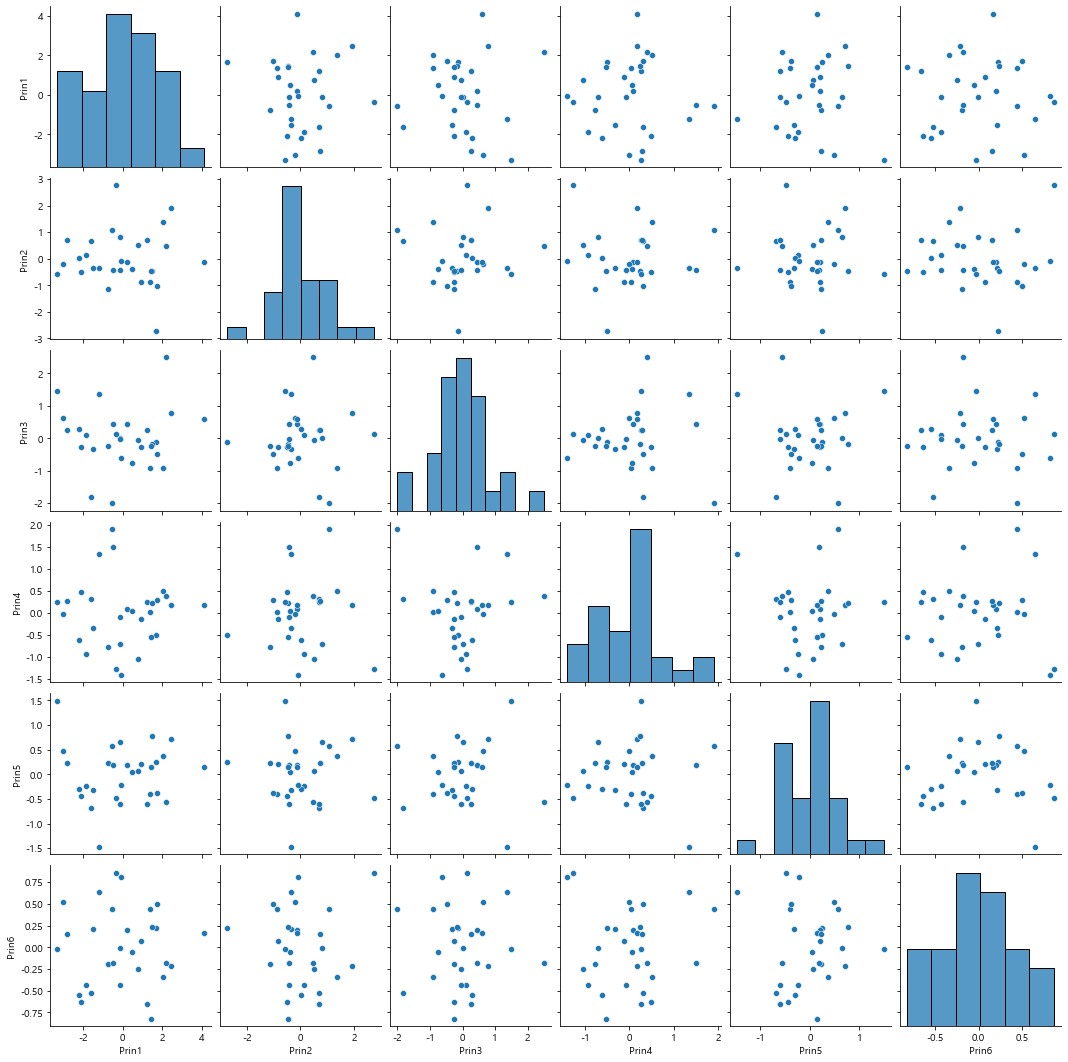

In [188]:
# 산점도 행렬
sns.pairplot(df_pca)

In [189]:
# 상관계수
df_pca.corr().round(3)

,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6
Prin1,1.0,0.0,-0.0,-0.0,-0.0,0.0
Prin2,0.0,1.0,0.0,-0.0,-0.0,0.0
Prin3,-0.0,0.0,1.0,0.0,0.0,-0.0
Prin4,-0.0,-0.0,0.0,1.0,-0.0,-0.0
Prin5,-0.0,-0.0,0.0,-0.0,1.0,-0.0
Prin6,0.0,0.0,-0.0,-0.0,-0.0,1.0


> 주성분은 서로 독립적. 상관계수=0

## 5. 주성분 상관/회귀분석

In [190]:
# 다중선형 회귀분석: 원천 데이터 활용
# 원천 데이터에 절편(const) 추가
df_raw_x_const=sm.add_constant(df_raw_x)
# 회귀 모델 생성
reg_model=sm.OLS(df_raw_y, df_raw_x_const)
# 회귀 모델 적합
reg_model=reg_model.fit()
# 모델 성능 확인
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   EVAL   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           1.24e-05
Time:                        15:45:37   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7871     11.589      0.931      0.3

In [192]:
# 다중선형 회귀분석: Scale 변환 데이터 활용
# Scale 변환 데이터에 절편(const) 컬럼 추가
df_scaled_const=sm.add_constant(df_scaled)
reg_model=sm.OLS(df_raw_y, df_scaled_const)
reg_model=reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   EVAL   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           1.24e-05
Time:                        15:46:57   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.6333      1.290     50.087      0.0

In [194]:
# 다중선형 주성분 회귀분석: 주성분 점수(score) 데이터 활용
# Eigenvalue, Scree plot 기준으로 적정 주성분 선택
x_var=["Prin1", "Prin2", "Prin3"]

# 선택된 주성분 점수 데이터에 절편(const) 컬럼 추가
df_pca_const=sm.add_constant(df_pca[x_var])

# 회귀모델 생성
reg_model=sm.OLS(df_raw_y, df_pca_const)
# 회귀모델 적합
reg_model=reg_model.fit()
# 모델 성능 확인
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   EVAL   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     14.36
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           1.02e-05
Time:                        15:49:16   Log-Likelihood:                -102.38
No. Observations:                  30   AIC:                             212.8
Df Residuals:                      26   BIC:                             218.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.6333      1.440     44.890      0.0

- 전체 설명변수를 이용한 모델보다 3개 주성분을 이용한 회귀모델의 설명력이 약 8% 저하됨.  
 => 기여율이 약한 주성분 3개(주성분 4~6)를 제외하여 설명력이 저하됨.
- 주성분 회귀분석의 회귀계수는 모두 유의함

# 주성분 분석(PCA)_실습

아래는 붓꽃의 품종 특성 데이터이다.  
꽃잎 및 꽃받침 길이와 넓이 자료를 이용해서 주성분 분석을 실시하고 결과를 해석하시오.
- 데이터: IRIS.CSV(변수: 5개, 자료 수 : 150개)

## 1. 데이터 구성하기

In [195]:
df_raw=pd.read_csv("../data/IRIS.csv", engine="python")
df_raw.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [196]:
# 데이터 분리(Y, Xs) -> 설명변수를 이용한 주성분 분석
df_raw_x=df_raw.drop("SPECIES", axis=1)
df_raw_y=df_raw["SPECIES"]
display(df_raw_y.head())
display(df_raw_x.head())

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: SPECIES, dtype: object

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 2. 선형관계 확인

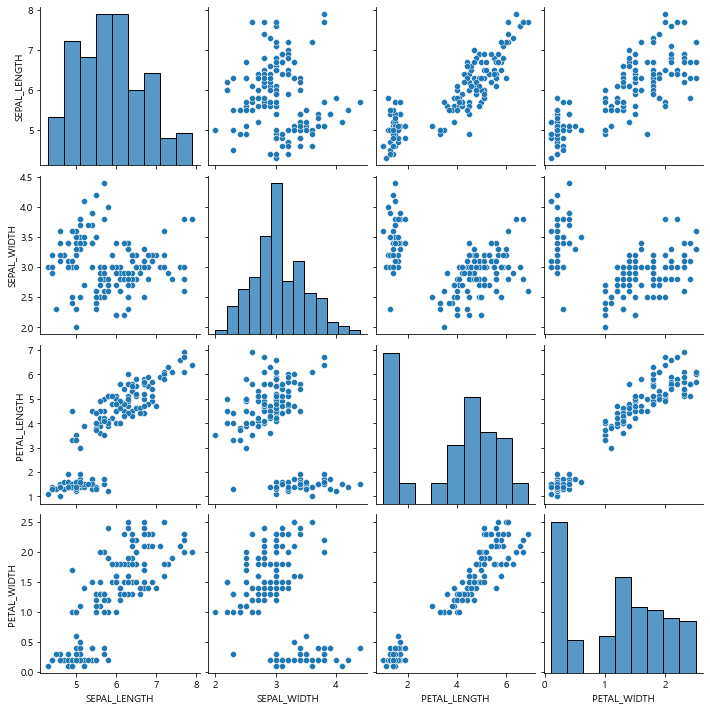

In [197]:
# 산점도 행렬
sns.pairplot(df_raw_x)

In [198]:
# Pearson 상관계수: pearson, kendall, spearman
df_raw_x.corr().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
SEPAL_LENGTH,1.000,-0.118,0.872,0.818
SEPAL_WIDTH,-0.118,1.000,-0.428,-0.366
PETAL_LENGTH,0.872,-0.428,1.000,0.963
PETAL_WIDTH,0.818,-0.366,0.963,1.000


> DISSATIS는 CHANCE(0.597), ADVANCE(0.669)와 상관관계가 높음  
> CHANCE는 ADVANCE(0.640)와 상관관계가 높음  

## 3. 데이터 확인 및 Scaling

In [199]:
# 요약 통계량 -> Scale 변환 필요 확인
df_raw_x.describe().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
count,150.000,150.000,150.000,150.000
mean,5.843,3.057,3.758,1.199
std,0.828,0.436,1.765,0.762
min,4.300,2.000,1.000,0.100
25%,5.100,2.800,1.600,0.300
50%,5.800,3.000,4.350,1.300
75%,6.400,3.300,5.100,1.800
max,7.900,4.400,6.900,2.500


In [200]:
# 변수 이름 저장
x_cols=df_raw_x.columns
# Scale 변환: ndarray 형식
scaler=StandardScaler()
nd_scaled=scaler.fit_transform(df_raw_x)
# 변환된 데이터 및 형태 확인
print("Scaled Data: \n {}".format(nd_scaled[:5].round(3)))
print("Shape:\n{}".format(nd_scaled.shape))

Scaled Data: 
 [[-0.901  1.019 -1.34  -1.315]
 [-1.143 -0.132 -1.34  -1.315]
 [-1.385  0.328 -1.397 -1.315]
 [-1.507  0.098 -1.283 -1.315]
 [-1.022  1.249 -1.34  -1.315]]
Shape:
(150, 4)


In [201]:
# DataFrame으로 저장
df_scaled=pd.DataFrame(nd_scaled, columns=x_cols)
df_scaled.head().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
0,-0.901,1.019,-1.340,-1.315
1,-1.143,-0.132,-1.340,-1.315
2,-1.385,0.328,-1.397,-1.315
3,-1.507,0.098,-1.283,-1.315
4,-1.022,1.249,-1.340,-1.315


In [202]:
# Scale 변환 데이터 요약 통계량
df_scaled.describe().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
count,150.000,150.000,150.000,150.000
mean,-0.000,-0.000,-0.000,-0.000
std,1.003,1.003,1.003,1.003
min,-1.870,-2.434,-1.568,-1.447
25%,-0.901,-0.592,-1.227,-1.184
50%,-0.053,-0.132,0.336,0.133
75%,0.675,0.559,0.763,0.791
max,2.492,3.091,1.786,1.712


## 4. 주성분 분석

In [204]:
# 주성분 분석: 주성분1(Prin1)~주성분6(Prin6) 생성 및 저장
pca=PCA(n_components=4)
nd_pca=pca.fit_transform(df_scaled)
# 생성된 주성분 점수 확인
print("PCA Data :\n{}".format(nd_pca[:5]))
# 생성된 주성분 점수 Row, Column 개수 확인
print("Shape: \n {}".format(nd_pca.shape))

PCA Data :
[[-2.26470281  0.4800266  -0.12770602 -0.0241682 ]
 [-2.08096115 -0.67413356 -0.23460885 -0.10300677]
 [-2.36422905 -0.34190802  0.04420148 -0.02837705]
 [-2.29938422 -0.59739451  0.09129011  0.06595556]
 [-2.38984217  0.64683538  0.0157382   0.03592281]]
Shape: 
 (150, 4)


In [205]:
# 주성분 점수 저장(Prin1~Prin6, DataFrame형식) 및 확인
df_pca=pd.DataFrame(nd_pca, columns=["Prin1", "Prin2", "Prin3", "Prin4"])
# 주성분 분석용 데이터와 주성분 점수 결합
df_scaled_pca = df_scaled.join(df_pca)
df_scaled_pca.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,Prin1,Prin2,Prin3,Prin4
0,-0.900681,1.019004,-1.340227,-1.315444,-2.264703,0.480027,-0.127706,-0.024168
1,-1.143017,-0.131979,-1.340227,-1.315444,-2.080961,-0.674134,-0.234609,-0.103007
2,-1.385353,0.328414,-1.397064,-1.315444,-2.364229,-0.341908,0.044201,-0.028377
3,-1.506521,0.098217,-1.283389,-1.315444,-2.299384,-0.597395,0.091290,0.065956
4,-1.021849,1.249201,-1.340227,-1.315444,-2.389842,0.646835,0.015738,0.035923


In [206]:
# 주성분 분석 통계량 저장:주성분 번호, Eigenvalue, Eigenvalue ratio
df_pca_stat=pd.DataFrame()
df_pca_stat["PrinNo"]=[l for l in range(1, 5)]
df_pca_stat["EigenValues"]=pca.explained_variance_
df_pca_stat["EigenValueRatio"]=pca.explained_variance_ratio_
df_pca_stat["CumEigenValueRatio"]=np.cumsum(pca.explained_variance_ratio_)
df_pca_stat.round(3)

,PrinNo,EigenValues,EigenValueRatio,CumEigenValueRatio
0,1,2.938,0.730,0.730
1,2,0.920,0.229,0.958
2,3,0.148,0.037,0.995
3,4,0.021,0.005,1.000


> 적정 주성분 선택  
> : 상관계수 기준(고유값>1) 2개  
> : 공분산 기준(고유값 누적비율>0.8) 3개  

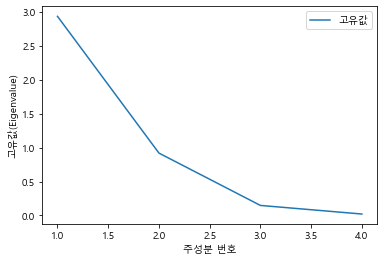

In [207]:
# Scree Plot
plt.plot(df_pca_stat["PrinNo"], df_pca_stat["EigenValues"], label="고유값")
# 그래프 label, legend 설정
plt.ylabel("고유값(Eigenvalue)")
plt.xlabel("주성분 번호")
plt.legend(loc="best")

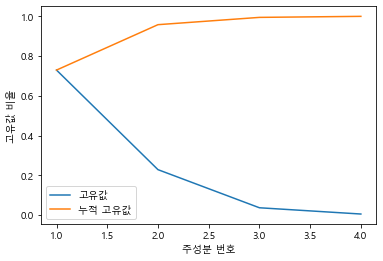

In [208]:
# 고유값 비율 그래프 생성
plt.plot(df_pca_stat["PrinNo"], df_pca_stat["EigenValueRatio"], label="고유값")
# 누적된 고유값 비율 그래프 생성
plt.plot(df_pca_stat["PrinNo"], df_pca_stat["CumEigenValueRatio"], label="누적 고유값")
plt.ylabel("고유값 비율")
plt.xlabel("주성분 번호")
plt.legend(loc="best")

In [210]:
# 주성분 분석 데이터의 변수 이름
x_cols=pd.DataFrame({"Feature":df_raw_x.columns})
# 주성분 Prin1~6까지의 고유벡터 저장
# 전치 결과 pd.DataFrame(pca.components_, columns=["Prin1", "Prin2", "Prin3", "Prin4", "Prin5", "Prin6"]), axis=1)
# 파이썬 PCA 분석 시 SVD 연산 방식의 차이 반영(전치, 부호 변경)
df_eigenvector=pd.concat([x_cols, pd.DataFrame(pca.components_.T*-1,\
                                              columns=["Prin1", "Prin2", "Prin3", "Prin4"])],axis=1)
df_eigenvector.round(3)

,Feature,Prin1,Prin2,Prin3,Prin4
0,SEPAL_LENGTH,-0.521,-0.377,0.720,0.261
1,SEPAL_WIDTH,0.269,-0.923,-0.244,-0.124
2,PETAL_LENGTH,-0.580,-0.024,-0.142,-0.801
3,PETAL_WIDTH,-0.565,-0.067,-0.634,0.524


> - 고유값 확인 및 주성분 해석  
> : 1 주성분은 배움 기회와 승진 간의 양의 연관성  
> : 2 주성분은 불만처리와 특권 허용 간의 음의 연관성 확인  
> - 분석가에 따라 다른 그룹 생성 및 해석 가능

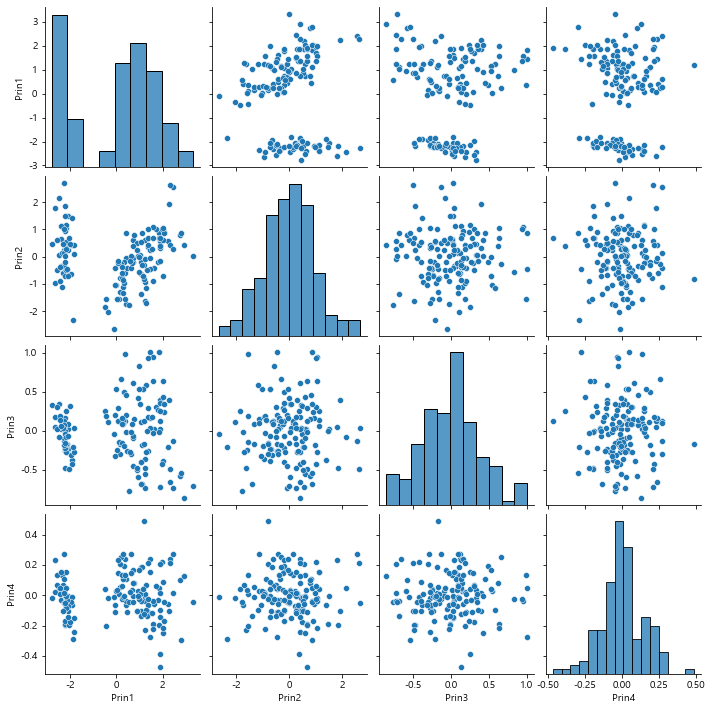

In [211]:
# 산점도 행렬
sns.pairplot(df_pca)

In [212]:
# 상관계수
df_pca.corr().round(3)

,Prin1,Prin2,Prin3,Prin4
Prin1,1.0,0.0,-0.0,-0.0
Prin2,0.0,1.0,-0.0,-0.0
Prin3,-0.0,-0.0,1.0,-0.0
Prin4,-0.0,-0.0,-0.0,1.0


> 주성분은 서로 독립적. 상관계수=0

# 시계열 분석

아래는 중국 위엔화(CNY), 일본 엔화(JPY) 그리고 미국 달러(USD)의 환율 데이터이다.  
중국 위엔화(CNY)의 변화 추세를 확인하고 시계열 분석을 이용하여 미래의 위엔화 환율을 예측하시오.  
- 데이터: 환율.CSV(변수: 4개, 자료 수: 273개, 기간: 20160101~20160331)

## 1. 데이터 구성하기

In [213]:
df_raw=pd.read_csv("../data/환율.csv", engine="python", parse_dates=["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


## 2. 변동 추세 확인

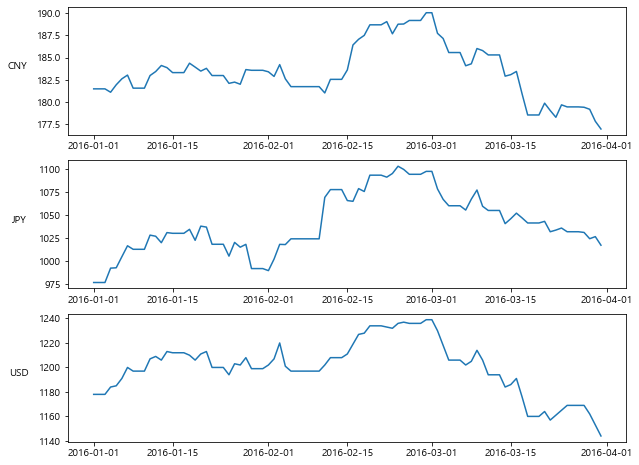

In [216]:
# 중국 위엔화와 엔화/달러 단위 크기가 다르기 때문에 각각 그래프 생성-> 3행 1열, 크기:(10,8)
fig, (ax1, ax2, ax3)=plt.subplots(nrows=3, ncols=1, figsize=(10,8))
# zip 함수를 사용하면 zip 함수 안의 리스트들을 하나씩 출력
# 1번 loop: ax1, 311, "CNY", # 2번 loop: ax2, 312, "JPY", # 3qjs loop: ax3, 313, "USD"
for (ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313], ["CNY", "JPY", "USD"]):
    # plot 추가, 311-> 3행 1열의 1번 그래프
    ax.plot("APPL_DATE", "STD_RATE", data=df_raw[df_raw["CURRENCY"]==currency])
    # y축에 통화 표시 rotation: label 가로로 생성, labelpad: label과 그래프 사이의 거리
    ax.set_ylabel(currency, rotation=0, labelpad=20)

## 3. 시계열 분석

In [218]:
# CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_CNY=df_raw[df_raw["CURRENCY"]=="CNY"].set_index("APPL_DATE")
# drop method를 이용하여 통화(CURRENCY)와 미달러 환산율(USD_CONV_DATE) 변수 제외
df_CNY.drop(["CURRENCY", "USD_CONV_DATE"], axis=1, inplace=True)
# JPY 데이터 생성
df_JPY=df_raw[df_raw["CURRENCY"]=="JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY", "USD_CONV_DATE"], axis=1, inplace=True)
# USD 데이터 생성: 실습용 데이터
df_USD=df_raw[df_raw["CURRENCY"]=="USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis=1, inplace=True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


> 중국 위엔화 환율 데이터

In [219]:
# Train & Test 데이터 분할: 비율 기준 mask 지정
train_size=0.9
len_idx=len(df_CNY.index)
mask=(np.arange(len_idx)/len_idx)<train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [221]:
# mask를 이용한 데이터 분할
df_CNY_train=df_CNY[mask]
df_CNY_test=df_CNY[~mask]
print("shape of train data:{}".format(df_CNY_train.shape))
print("shape of test data:{}".format(df_CNY_test.shape))

shape of train data:(82, 1)
shape of test data:(9, 1)


In [222]:
# 추가설명: Train & Test 데이터 분할: index 직접 지정
df_CNY_train=df_CNY[df_CNY.index<="2016-03-22"]
df_CNY_test=df_CNY[df_CNY.index>"2016-03-22"]
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


<AxesSubplot:xlabel='APPL_DATE'>

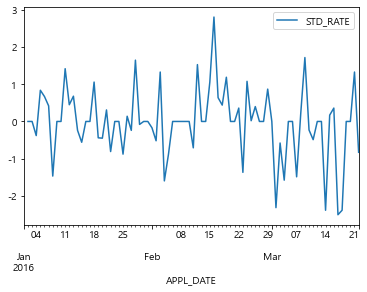

In [223]:
# 1차 차분: z(t) - z(t-1)
# shift(n): 앞의 n번 째 행의 데이터를 가져옴
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

> 원 데이터보다는 시간의 흐름에 영향을 덜 받지만 정상성이 만족스럽지 않음

<AxesSubplot:xlabel='APPL_DATE'>

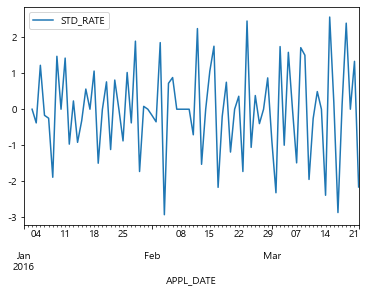

In [224]:
# 2차 차분: (z(t)-z(t-1))-(z(t-1)-z(t-2))=z(t)-2*z(t-1)+z(t-2)
df_CNY_diff2=df_CNY_train-2*(df_CNY_train.shift(1))+(df_CNY_train.shift(2))
df_CNY_diff2.plot()

> (2차 차분으로) 시간에 따른 경향성을 가지지 않는 정상성을 만족

- Lag를 30까지 하여 ACF, PACF 산출

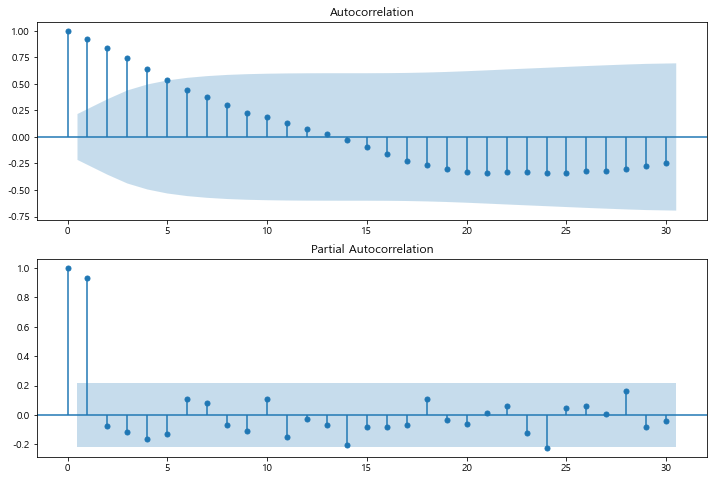

In [227]:
# 자기회귀 최대 p기간 지정
lag_size=30
fig=plt.figure(figsize=(12,8))
# acf 그래프를 그릴 공간 생성
ax1=fig.add_subplot(211)
# 자기상관 함수 그래프 plot_acf 함수 사용
fig = plot_acf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax1) # ["STD_RATE"] 생략 가능
# pacf 그래프를 그릴 공간 생성
ax2=fig.add_subplot(212)
# 부분 자기상관 함수 그래프 plot_pacf 함수 사용
fig=plot_pacf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax2) #["STD_RATE"] 생략 가능

In [228]:
# Train 데이터 이용, AR(1), 1(2, 차분), MA(0)인 ARIMA 모델
ts_model_cny=ARIMA(df_CNY_train, order=(1, 2, 0)) # (p, d, q) 지정
# 데이터 적합
# trend: 상수 포함 여부 "nc"이면 상수 미포함, full_output: 모든 출력 결과 표시
ts_result_cny=ts_model_cny.fit(trend="c", full_output=True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Wed, 03 Mar 2021   AIC                            253.025
Time:                        17:08:33   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

C:\Users\82105\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

> ARIMA(1, 2, 0) 모델의 계수 유의성 확인

## 4. 예측 및 결과 해석

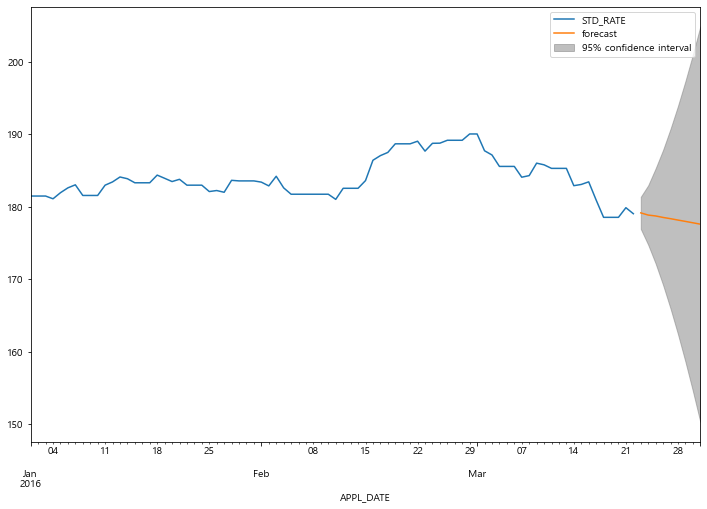

In [229]:
# 예측 시작/종료 날짜 지정
start_time=df_CNY_test.index.min() #2016-03-23
end_time=df_CNY_test.index.max() #2016-03-31
fig, ax=plt.subplots(figsize=(12,8))
# 예측 전까지 데이터
ax=df_CNY_train.plot(ax=ax)
# 예측 그래프 생성 함수, start: 예측 시작, end: 예측 종료, plot_insample:가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시
fig=ts_result_cny.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

> - 2016년 3월 31일까지의 예측값 -> 지속적으로 감소할 것으로 예측  
> - 예측값에 대한 95% 신뢰구간 (상, 하 회색 영역)

In [230]:
# 전체 기간의 실제값, 예측값 확인
start_time=pd.to_datetime("2016-01-03") # 차분=2-> 시작일자 + 2 이후부터 예측값 생성됨
y_pred=ts_result_cny.predict(start=start_time, end=end_time, typ='levels')
df_merge=df_CNY # 실제값 저장
df_merge["예측값"]=y_pred # 예측값 저장 및 변수명 지정
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476897
2016-01-05,181.94,180.883667


<AxesSubplot:xlabel='APPL_DATE'>

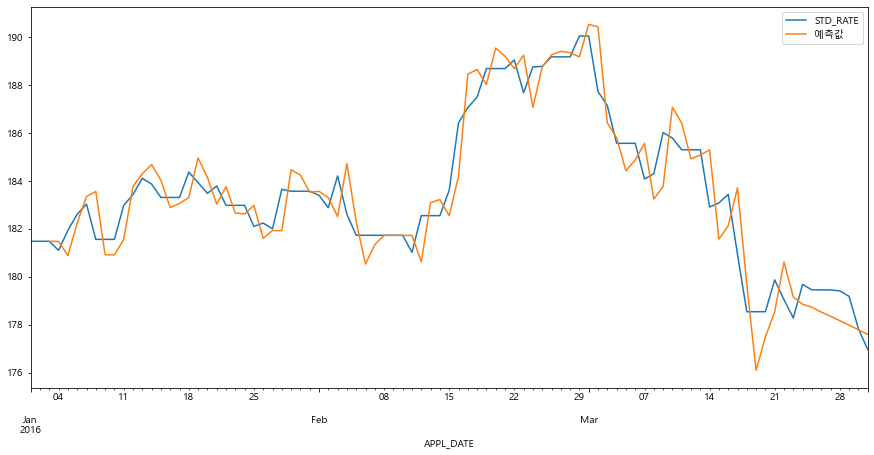

In [232]:
# 추세 그래프 생성 및 확인
df_merge.plot(y=["STD_RATE", "예측값"], figsize=(15, 7))

> 모델 훈련구간은 실제값 대비 지연(lag) 현상이 확인되며 예측구간은 오차가 큼